In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

### Для боле наглядного отображения разделяющих гиперплоскостей были использованы 300 точек и 5 признаков.

In [3]:
classification_data, classification_labels = datasets.make_classification(n_samples=300,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

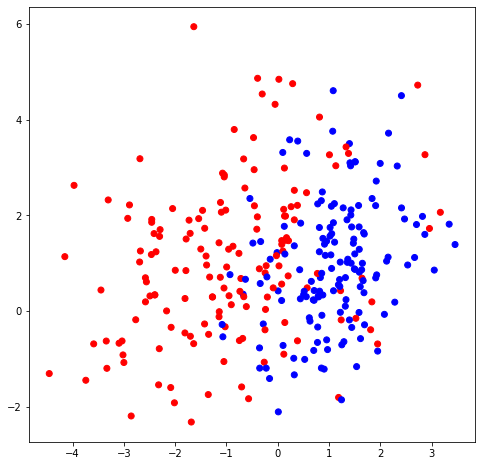

In [4]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [5]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [6]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [15]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [18]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [19]:
train_data.shape

(210, 5)

In [20]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [21]:
n_trees_1 = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees_1)
train_answers_1 = tree_vote(my_forest_1, train_data)
test_answers_1 = tree_vote(my_forest_1, test_data)
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
test_accuracy_1 = accuracy_metric(test_labels, test_answers_1)


n_trees_2 = 3
my_forest_2 = random_forest(train_data, train_labels, n_trees_2)
train_answers_2 = tree_vote(my_forest_2, train_data)
test_answers_2 = tree_vote(my_forest_2, test_data)
train_accuracy_2 = accuracy_metric(train_labels, train_answers_2)
test_accuracy_2 = accuracy_metric(test_labels, test_answers_2)


n_trees_3 = 10
my_forest_3 = random_forest(train_data, train_labels, n_trees_3)
train_answers_3 = tree_vote(my_forest_3, train_data)
test_answers_3 = tree_vote(my_forest_3, test_data)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)


n_trees_4 = 50
my_forest_4 = random_forest(train_data, train_labels, n_trees_4)
train_answers_4 = tree_vote(my_forest_4, train_data)
test_answers_4 = tree_vote(my_forest_4, test_data)
train_accuracy_4 = accuracy_metric(train_labels, train_answers_4)
test_accuracy_4 = accuracy_metric(test_labels, test_answers_4)


acc_tr = [train_accuracy_1,train_accuracy_2,train_accuracy_3,train_accuracy_4]
acc_tst = [test_accuracy_1,test_accuracy_2,test_accuracy_3,test_accuracy_4]
acc_x = [1,3,10,50]

### Так как плоскости тестовых и тренровочных выборок практически одинаково выглядят, принято решение для построения плоскостей использовать только тестовые выборки.

Точность случайного леса из 1 деревьев на обучающей выборке: 92.857
Точность случайного леса из 3 деревьев на обучающей выборке: 96.667
Точность случайного леса из 10 деревьев на обучающей выборке: 98.095
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 1 деревьев на тестовой выборке: 83.333
Точность случайного леса из 3 деревьев на тестовой выборке: 81.111
Точность случайного леса из 10 деревьев на тестовой выборке: 84.444
Точность случайного леса из 50 деревьев на тестовой выборке: 87.778


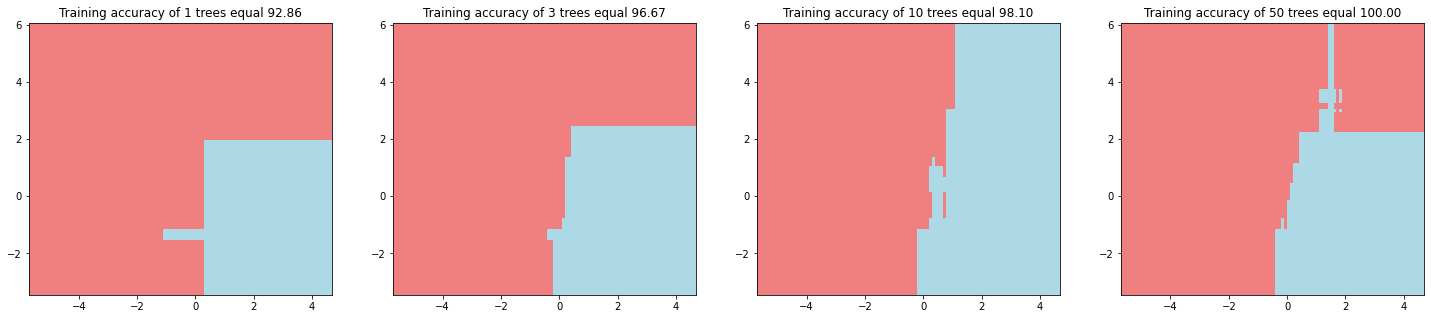

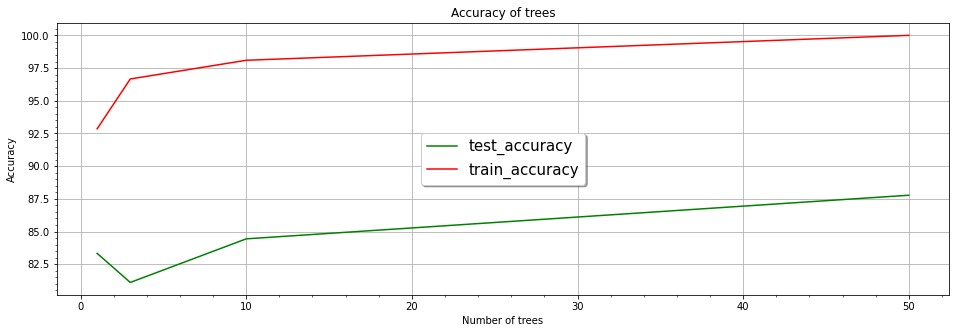

In [22]:
def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr

plt.figure(figsize = (25, 5))
plt.subplot(1,4,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_1,gr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.title(f'Training accuracy of {n_trees_1} trees equal {train_accuracy_1:.2f}')
plt.subplot(1,4,2)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_2,gr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.title(f'Training accuracy of {n_trees_2} trees equal {train_accuracy_2:.2f}')
plt.subplot(1,4,3)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_3,gr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.title(f'Training accuracy of {n_trees_3} trees equal {train_accuracy_3:.2f}')
plt.subplot(1,4,4)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_4,gr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.title(f'Training accuracy of {n_trees_4} trees equal {train_accuracy_4:.2f}')

plt.figure(figsize = (16, 5))
plt.plot(acc_x, acc_tst, color='g', label = 'test_accuracy')
plt.plot(acc_x, acc_tr, color='r', label = 'train_accuracy')
plt.title('Accuracy of trees')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend(loc = 'center', shadow = True, fontsize = 15)
plt.minorticks_on()
plt.grid(True)

print(f'Точность случайного леса из {n_trees_1} деревьев на обучающей выборке: {train_accuracy_1:.3f}')
print(f'Точность случайного леса из {n_trees_2} деревьев на обучающей выборке: {train_accuracy_2:.3f}')
print(f'Точность случайного леса из {n_trees_3} деревьев на обучающей выборке: {train_accuracy_3:.3f}')
print(f'Точность случайного леса из {n_trees_4} деревьев на обучающей выборке: {train_accuracy_4:.3f}')
print(f'Точность случайного леса из {n_trees_1} деревьев на тестовой выборке: {test_accuracy_1:.3f}')
print(f'Точность случайного леса из {n_trees_2} деревьев на тестовой выборке: {test_accuracy_2:.3f}')
print(f'Точность случайного леса из {n_trees_3} деревьев на тестовой выборке: {test_accuracy_3:.3f}')
print(f'Точность случайного леса из {n_trees_4} деревьев на тестовой выборке: {test_accuracy_4:.3f}')

### Вывод: как можно видеть по гиперплоскостям и графику accuracy, переобучение возникает при использовании 3-х деревьев, а далее результаты train и test возрастают, достигая наилучших значений при использовании 50-и деревьев. При этом образуется самое большое количество граней гиперплоскости и значительно увеличивается время расчетов.